In [1]:
notebook_mode = True
viz_mode = False

In [2]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
only_xy = [[1,2],[4,5],[3,2],[6,9]]
test = pdist(only_xy, metric='euclidean')
test[0] = np.inf
print(test)

[       inf 2.         8.60232527 3.16227766 4.47213595 7.61577311]


In [3]:
import os
import json
import argparse
import time

import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from tensorboardX import SummaryWriter
from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.google_tsp_reader import GoogleTSPReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

/opt/anaconda3/envs/pytorch_0.4.1/lib/python3.6/site-packages/fastprogress/fastprogress.py:26: UserWarning: Couldn't import ipywidgets properly, progress bar will use console behavior
  warn("Couldn't import ipywidgets properly, progress bar will use console behavior")


In [4]:
if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

# Load configurations

In [5]:
if notebook_mode==False:
    parser = argparse.ArgumentParser(description='gcn_tsp_parser')
    parser.add_argument('-c','--config', type=str, default="configs/default.json")
    args = parser.parse_args()
    config_path = args.config
elif viz_mode == True:
    config_path = "configs/default.json"
else:
    config_path = "configs/default.json"

config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/default.json:
{'expt_name': 'deafult', 'gpu_id': '0', 'train_filepath': './data/tsp25_concorde.txt', 'val_filepath': './data/tsp25_concorde.txt', 'test_filepath': './data/tsp25_concorde.txt', 'num_nodes': 100, 'num_neighbors': 8, 'node_dim': 4, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 10, 'hidden_dim': 50, 'num_layers': 3, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 50, 'val_every': 5, 'test_every': 10, 'batch_size': 100, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


In [6]:
# Over-ride config params (for viz_mode)
if viz_mode==True:
    config.gpu_id = "0"
    config.batch_size = 1
    config.accumulation_steps = 1
    config.beam_size = 1280
    
    # Uncomment below to evaluate generalization to variable sizes in viz_mode
#     config.num_nodes = 50
#     config.num_neighbors = 20
#     config.train_filepath = f"./data/tsp{config.num_nodes}_train_concorde.txt"
#     config.val_filepath = f"./data/tsp{config.num_nodes}_val_concorde.txt"
#     config.test_filepath = f"./data/tsp{config.num_nodes}_test_concorde.txt"

# Configure GPU options

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu_id)  

In [8]:
if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

CUDA not available


# Test data loading

Number of batches of size 100: 1
edges: (100, 100, 100)
edges_values: (100, 100, 100)
edges_targets: (100, 100, 100)
nodes: (100, 100)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
nodes_target: (100, 100)
nodes_coord: (100, 100, 4)
tour_nodes: (100, 110)
tour_len: (100,)


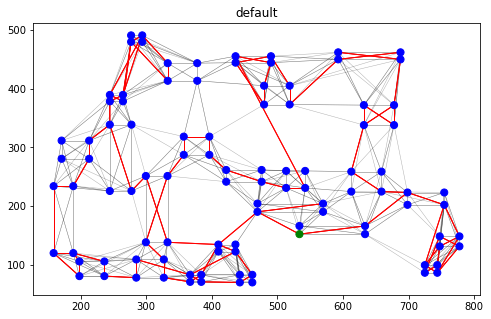

In [9]:
if notebook_mode:
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = config.batch_size
    train_filepath = config.train_filepath
    dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size, train_filepath)
    print("Number of batches of size {}: {}".format(batch_size, dataset.max_iter))

    t = time.time()
    batch = next(iter(dataset))  # Generate a batch of TSPs

    print("edges:", batch.edges.shape)
    print("edges_values:", batch.edges_values.shape)
    print("edges_targets:", batch.edges_target.shape)
    print("nodes:", batch.nodes.shape)
    print(batch.nodes[0])
    print("nodes_target:", batch.nodes_target.shape)
    print("nodes_coord:", batch.nodes_coord.shape)
    print("tour_nodes:", batch.tour_nodes.shape)
    print("tour_len:", batch.tour_len.shape)

    idx = 19
    f = plt.figure(figsize=(8, 5))
    a = f.add_subplot(111)
    plot_tsp(a, batch.nodes_coord[idx][:,(0,1)], batch.edges[idx], batch.edges_values[idx], batch.edges_target[idx])

In [10]:
# Uncomment below to automatically compute the number of nearest neighbors to use in k-NN input graph
# if config.num_neighbors == -1:
#     dataset = GoogleTSPReader(config.num_nodes, config.num_neighbors, config.batch_size, config.train_filepath)
#     config.num_neighbors = get_max_k(dataset, max_iter=10000//config.batch_size)
#     print(f"New num_neighbors for k-NN input: {config.num_neighbors}")

# Instantiate model

In [11]:
if notebook_mode == True:
    # Instantiate the network
    #nn.DataParallel
    net = ResidualGatedGCNModel(config, dtypeFloat, dtypeLong)
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
    
    # Define optimizer
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

ResidualGatedGCNModel(
  (nodes_coord_embedding): Linear(in_features=4, out_features=50, bias=False)
  (edges_values_embedding): Linear(in_features=1, out_features=25, bias=False)
  (edges_embedding): Embedding(3, 25)
  (gcn_layers): ModuleList(
    (0): ResidualGatedGCNLayer(
      (node_feat): NodeFeatures(
        (U): Linear(in_features=50, out_features=50, bias=True)
        (V): Linear(in_features=50, out_features=50, bias=True)
      )
      (edge_feat): EdgeFeatures(
        (U): Linear(in_features=50, out_features=50, bias=True)
        (V): Linear(in_features=50, out_features=50, bias=True)
      )
      (bn_node): BatchNormNode(
        (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
      (bn_edge): BatchNormEdge(
        (batch_norm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      )
    )
    (1): ResidualGatedGCNLayer(
      (node_feat): NodeFeatures(
        (U): Linear(in_feat

# Test forward pass

In [12]:
if notebook_mode == True and viz_mode == False:
    # Generate a batch of TSPs
    num_nodes = config.num_nodes
    print(config.node_dim)
    num_neighbors = config.num_neighbors
    batch_size = config.batch_size
    train_filepath = config.train_filepath
    dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, train_filepath))
    batch = next(dataset)

    # Convert batch to torch Variables
    x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
    x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
    x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
    x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
    y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
    y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
    # Compute class weights
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
    print("Class weights: {}".format(edge_cw))
        
    # Forward pass
    y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
    loss = loss.mean()
    print("Output size: {}".format(y_preds.size()))
    print("Loss value:", loss)

4
Class weights: [ 0.50890585 28.57142857]
Output size: torch.Size([100, 100, 100, 2])
Loss value: tensor(22.9468, grad_fn=<MeanBackward1>)


# Test backward pass

In [13]:
if notebook_mode == True and viz_mode == False:
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Compute error metrics 
    err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
    print("Edge error: {:.3f}\nTour error: {:.3f}\nTSP error: {:.3f}".format(err_edges, err_tour, err_tsp))
    
    # Compute mean predicted and groundtruth tour length
    pred_tour_len = mean_tour_len_edges(x_edges_values, y_preds)
    gt_tour_len = np.mean(batch.tour_len) 
    print("Predicted tour length: {:.3f}\nGroundtruth tour length: {:.3f}".format(pred_tour_len, gt_tour_len))

Edge error: 82.800
Tour error: 0.000
TSP error: 98.249
Predicted tour length: 1378865.920
Groundtruth tour length: 6021.430


# Training Loop (one epoch)

In [14]:
def train_one_epoch(net, optimizer, config, master_bar):
    # Set training mode
    net.train()

    # Assign parameters
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    train_filepath = config.train_filepath

    # Load TSP data
    dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size, train_filepath)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0

    start_epoch = time.time()
    for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        loss = loss.mean()  # Take mean of loss across multiple GPUs
        loss = loss / accumulation_steps  # Scale loss by accumulation steps
        loss.backward()

        # Backward pass
        if (batch_num+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Compute error metrics and mean tour lengths
        # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
        pred_tour_len = mean_tour_len_edges(x_edges_values, y_preds)
        gt_tour_len = np.mean(batch.tour_len)

        # Update running data
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()* accumulation_steps  # Re-scale loss
        # running_err_edges += batch_size* err_edges
        # running_err_tour += batch_size* err_tour
        # running_err_tsp += batch_size* err_tsp
        running_pred_tour_len += batch_size* pred_tour_len
        running_gt_tour_len += batch_size* gt_tour_len
        running_nb_batch += 1
        
        # Log intermediate statistics
        result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
            loss=running_loss/running_nb_data,
            pred_tour_len=running_pred_tour_len/running_nb_data,
            gt_tour_len=running_gt_tour_len/running_nb_data))
        master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_epoch, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len


def metrics_to_str(epoch, time, learning_rate, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len):
    result = ( 'epoch:{epoch:0>2d}\t'
               'time:{time:.1f}h\t'
               'lr:{learning_rate:.2e}\t'
               'loss:{loss:.4f}\t'
               # 'err_edges:{err_edges:.2f}\t'
               # 'err_tour:{err_tour:.2f}\t'
               # 'err_tsp:{err_tsp:.2f}\t'
               'pred_tour_len:{pred_tour_len:.3f}\t'
               'gt_tour_len:{gt_tour_len:.3f}'.format(
                   epoch=epoch,
                   time=time/3600,
                   learning_rate=learning_rate,
                   loss=loss,
                   # err_edges=err_edges,
                   # err_tour=err_tour,
                   # err_tsp=err_tsp,
                   pred_tour_len=pred_tour_len,
                   gt_tour_len=gt_tour_len))
    return result

In [15]:
if notebook_mode==True and viz_mode==False:
    epoch_bar = master_bar(range(1))
    for epoch in epoch_bar:
        train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len = train_one_epoch(net, optimizer, config, epoch_bar)
        epoch_bar.write('t: ' + metrics_to_str(epoch, train_time, learning_rate, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len))

t: epoch:00	time:0.0h	lr:1.00e-03	loss:16.8244	pred_tour_len:1378865.920	gt_tour_len:6021.430


# Evaluation Loop (for validation and test sets)

In [16]:
def test(net, config, master_bar, mode='test'):
    # Set evaluation mode
    net.eval()

    # Assign parameters
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    beam_size = config.beam_size
    val_filepath = config.val_filepath
    test_filepath = config.test_filepath

    # Load TSP data
    if mode == 'val':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size=batch_size, filepath=val_filepath)
    elif mode == 'test':
        dataset = GoogleTSPReader(num_nodes, num_neighbors, batch_size=batch_size, filepath=test_filepath)
    batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_pred_tour_len = 0.0
    running_gt_tour_len = 0.0
    running_nb_data = 0
    running_nb_batch = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
            x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
            x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
            x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
            y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
            y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
            
            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)

            # Forward pass
            y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs

            # Compute error metrics
            # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)

            # Get batch beamsearch tour prediction
            if mode == 'val':  # Validation: faster 'vanilla' beamsearch
                bs_nodes = beamsearch_tour_nodes(
                    y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            elif mode == 'test':  # Testing: beamsearch with shortest tour heuristic 
                bs_nodes = beamsearch_tour_nodes_shortest(
                    y_preds, x_edges_values, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
            
            # Compute mean tour length
            pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
            gt_tour_len = np.mean(batch.tour_len)

            # Update running data
            running_nb_data += batch_size
            running_loss += batch_size* loss.data.item()
            # running_err_edges += batch_size* err_edges
            # running_err_tour += batch_size* err_tour
            # running_err_tsp += batch_size* err_tsp
            running_pred_tour_len += batch_size* pred_tour_len
            running_gt_tour_len += batch_size* gt_tour_len
            running_nb_batch += 1

            # Log intermediate statistics
            result = ('loss:{loss:.4f} pred_tour_len:{pred_tour_len:.3f} gt_tour_len:{gt_tour_len:.3f}'.format(
                loss=running_loss/running_nb_data,
                pred_tour_len=running_pred_tour_len/running_nb_data,
                gt_tour_len=running_gt_tour_len/running_nb_data))
            master_bar.child.comment = result

    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    pred_tour_len = running_pred_tour_len/ running_nb_data
    gt_tour_len = running_gt_tour_len/ running_nb_data

    return time.time()-start_test, loss, err_edges, err_tour, err_tsp, pred_tour_len, gt_tour_len

In [17]:
if notebook_mode==True and viz_mode==False:
    epoch_bar = master_bar(range(1))
    for epoch in epoch_bar:
        # Validation
        val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
        epoch_bar.write('v: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
        # Testing
        test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')
        epoch_bar.write('T: ' + metrics_to_str(epoch, test_time, learning_rate, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len))

v: epoch:00	time:0.0h	lr:1.00e-03	loss:11.0524	pred_tour_len:32765.621	gt_tour_len:6021.430
T: epoch:00	time:0.0h	lr:1.00e-03	loss:11.0524	pred_tour_len:32663.030	gt_tour_len:6021.430


# Run full training pipeline 

In [18]:
def main(config):
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
 
    # Create log directory
    log_dir = f"./logs/{config.expt_name}/"
    os.makedirs(log_dir, exist_ok=True)
    json.dump(config, open(f"{log_dir}/config.json", "w"), indent=4)
    writer = SummaryWriter(log_dir)  # Define Tensorboard writer

    # Training parameters
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    max_epochs = config.max_epochs
    val_every = config.val_every
    test_every = config.test_every
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    learning_rate = config.learning_rate
    decay_rate = config.decay_rate
    val_loss_old = 1e6  # For decaying LR based on validation loss
    best_pred_tour_len = 1e6  # For saving checkpoints

    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

    epoch_bar = master_bar(range(max_epochs))
    for epoch in epoch_bar:
        # Log to Tensorboard
        writer.add_scalar('learning_rate', learning_rate, epoch)
        
        # Train
        train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len = train_one_epoch(net, optimizer, config, epoch_bar)
        epoch_bar.write('t: ' + metrics_to_str(epoch, train_time, learning_rate, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_pred_tour_len, train_gt_tour_len))
        writer.add_scalar('loss/train_loss', train_loss, epoch)
        writer.add_scalar('pred_tour_len/train_pred_tour_len', train_pred_tour_len, epoch)
        writer.add_scalar('optimality_gap/train_opt_gap', train_pred_tour_len/train_gt_tour_len - 1, epoch)

        if epoch % val_every == 0 or epoch == max_epochs-1:
            # Validate
            val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
            epoch_bar.write('v: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
            writer.add_scalar('loss/val_loss', val_loss, epoch)
            writer.add_scalar('pred_tour_len/val_pred_tour_len', val_pred_tour_len, epoch)
            writer.add_scalar('optimality_gap/val_opt_gap', val_pred_tour_len/val_gt_tour_len - 1, epoch)
            
            # Save checkpoint
            if val_pred_tour_len < best_pred_tour_len:
                best_pred_tour_len = val_pred_tour_len  # Update best prediction
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                }, log_dir+"best_val_checkpoint.tar")
            
            # Update learning rate
            if val_loss > 0.99 * val_loss_old:
                learning_rate /= decay_rate
                optimizer = update_learning_rate(optimizer, learning_rate)
            
            val_loss_old = val_loss  # Update old validation loss

        if epoch % test_every == 0 or epoch == max_epochs-1:
            # Test
            test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')
            epoch_bar.write('T: ' + metrics_to_str(epoch, test_time, learning_rate, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len))
            writer.add_scalar('loss/test_loss', test_loss, epoch)
            writer.add_scalar('pred_tour_len/test_pred_tour_len', test_pred_tour_len, epoch)
            writer.add_scalar('optimality_gap/test_opt_gap', test_pred_tour_len/test_gt_tour_len - 1, epoch)
        
        # Save training checkpoint at the end of epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, log_dir+"last_train_checkpoint.tar")
        
        # Save checkpoint after every 250 epochs
        if epoch != 0 and (epoch % 250 == 0 or epoch == max_epochs-1):
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, log_dir+f"checkpoint_epoch{epoch}.tar")
        
    return net

In [19]:
if viz_mode==False:
    # del net
    net = main(config)

DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_coord_embedding): Linear(in_features=4, out_features=50, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=25, bias=False)
    (edges_embedding): Embedding(3, 25)
    (gcn_layers): ModuleList(
      (0): ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
      )
      (1): ResidualGatedGC

t: epoch:46	time:0.0h	lr:9.71e-04	loss:0.2729	pred_tour_len:88434.800	gt_tour_len:6021.430
t: epoch:47	time:0.0h	lr:9.71e-04	loss:0.2520	pred_tour_len:67799.145	gt_tour_len:6021.430
t: epoch:48	time:0.0h	lr:9.71e-04	loss:0.2316	pred_tour_len:51153.995	gt_tour_len:6021.430
t: epoch:49	time:0.0h	lr:9.71e-04	loss:0.2184	pred_tour_len:38473.585	gt_tour_len:6021.430
v: epoch:49	time:0.0h	lr:9.71e-04	loss:0.2220	pred_tour_len:4662.012	gt_tour_len:6021.430
T: epoch:49	time:0.0h	lr:9.71e-04	loss:0.2220	pred_tour_len:4657.853	gt_tour_len:6021.430


# Load saved checkpoint

In [20]:
if notebook_mode==True:
    # Load checkpoint
    log_dir = f"./logs/{config.expt_name}/"
    if torch.cuda.is_available():
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar")
    else:
        checkpoint = torch.load(log_dir+"best_val_checkpoint.tar", map_location='cpu')
    # Load network state
    net.load_state_dict(checkpoint['model_state_dict'])
    # Load optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Load other training parameters
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
    for param_group in optimizer.param_groups:
        learning_rate = param_group['lr']
    print(f"Loaded checkpoint from epoch {epoch}")    

Loaded checkpoint from epoch 10


# Visualize model predictions

Class weights: [ 0.50890585 28.57142857]
torch.Size([10, 100, 100, 2])
Predicted tour length: 4119.638 (mean)
Groundtruth tour length: 6021.430 (mean)


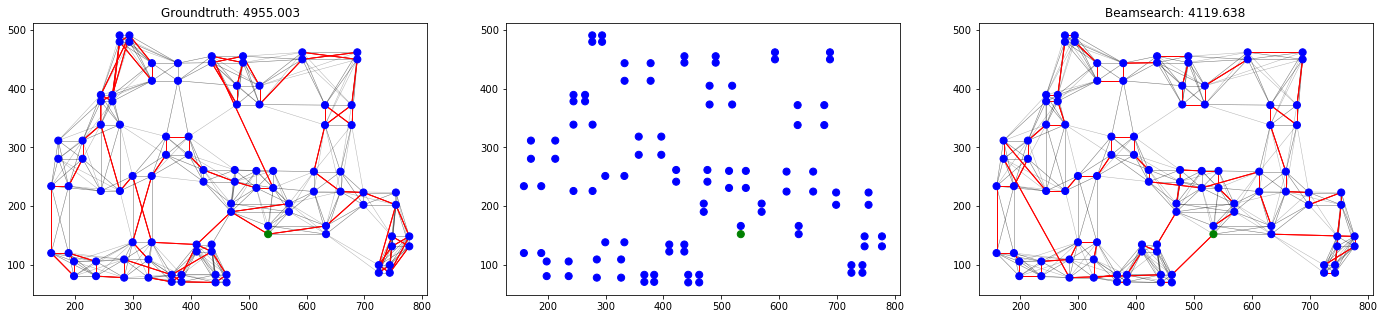

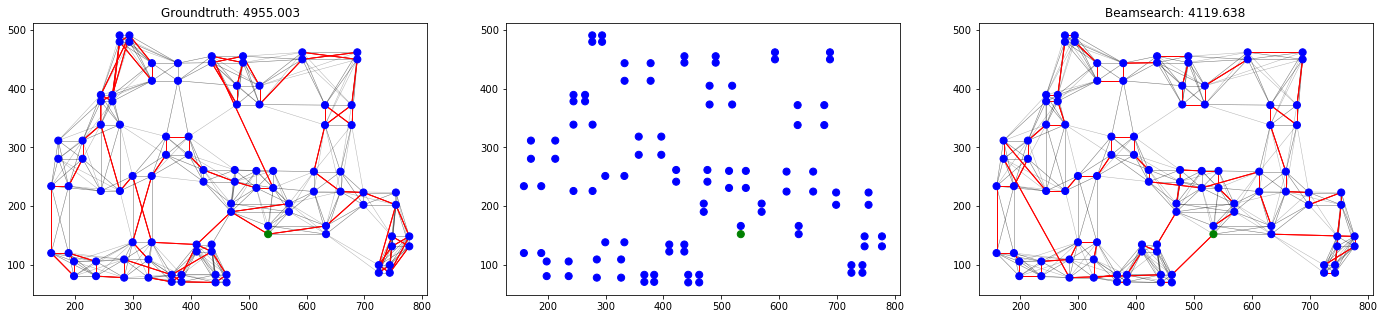

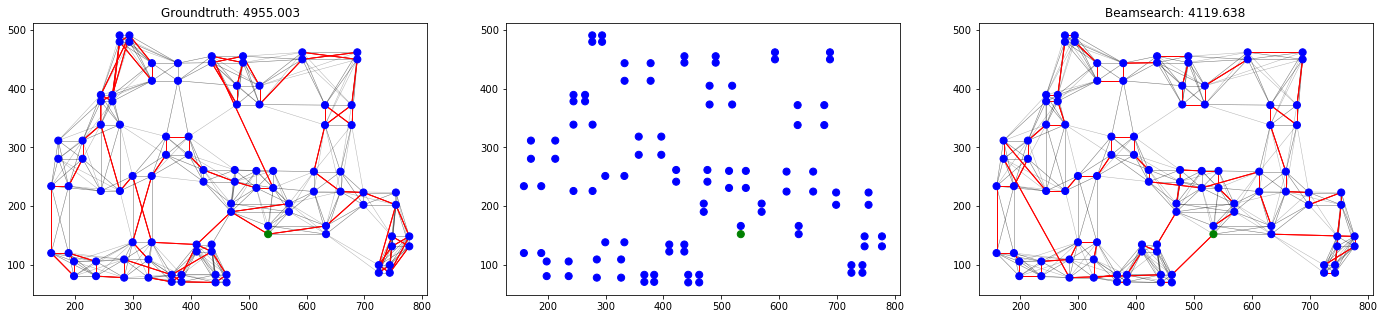

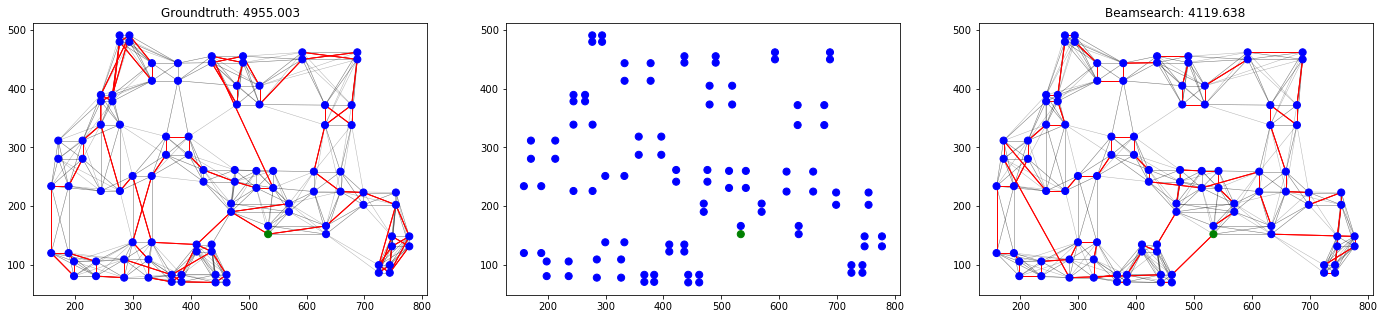

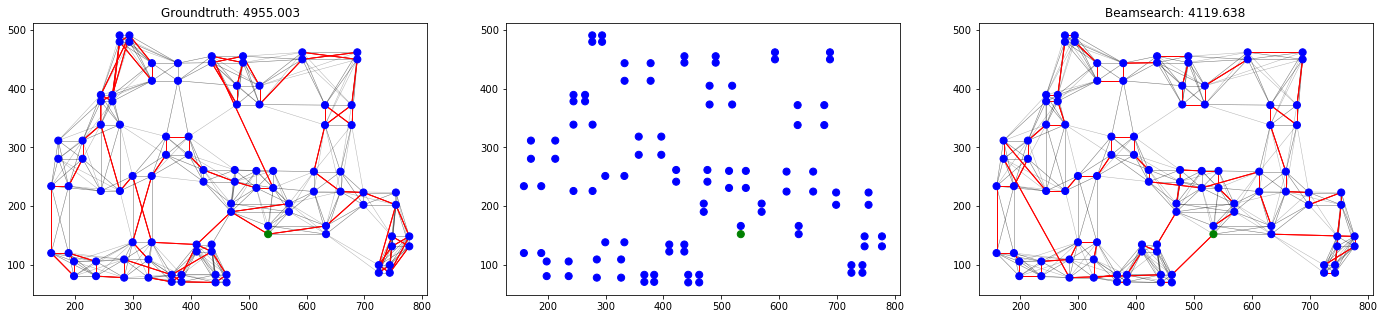

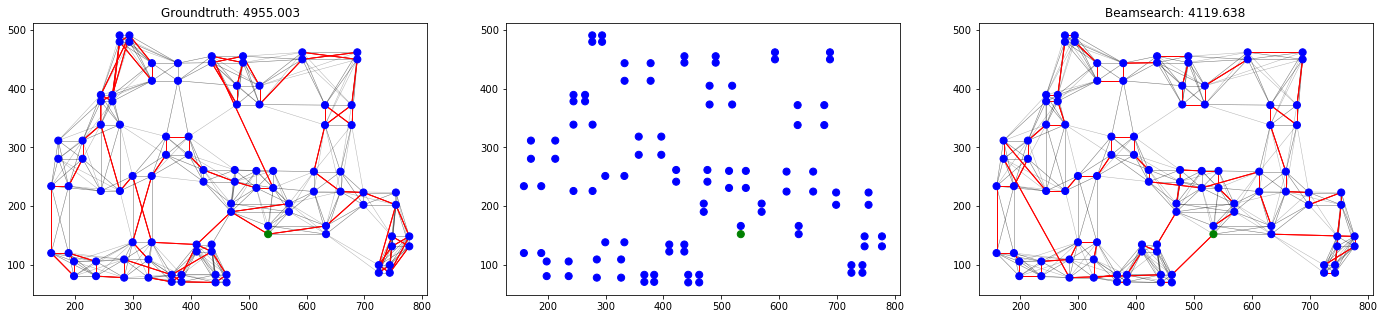

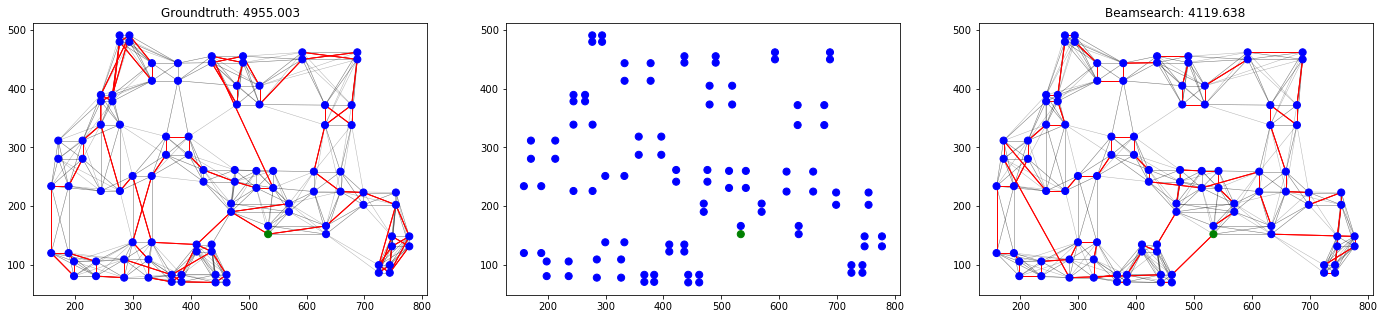

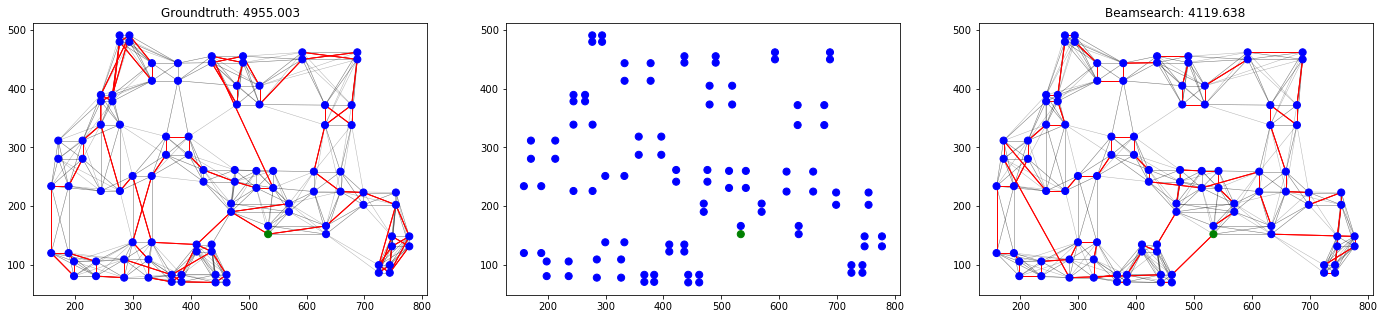

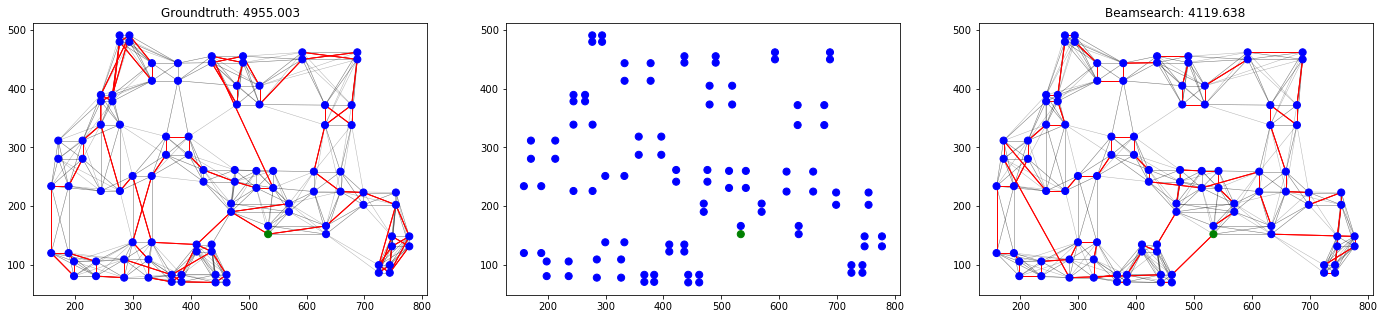

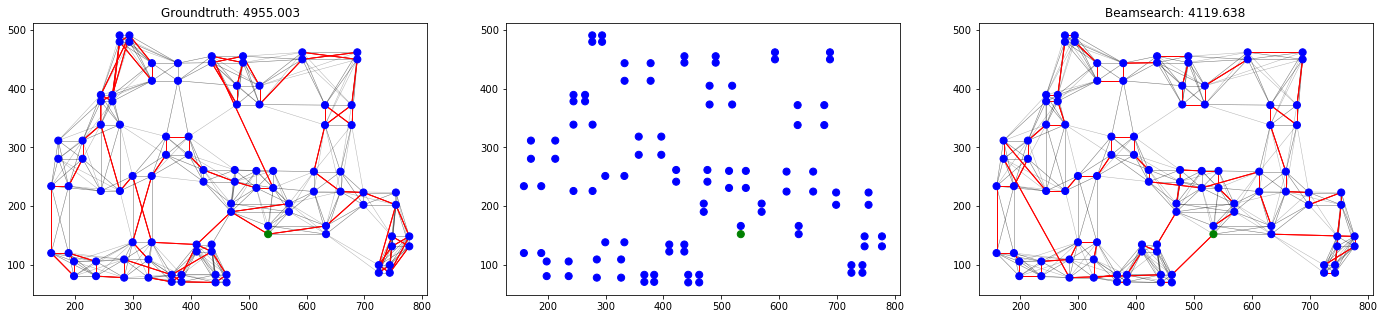

In [21]:
if notebook_mode==True:
    # Set evaluation mode
    net.eval()
    
    batch_size = 10
    num_nodes = config.num_nodes
    num_neighbors = config.num_neighbors
    beam_size = config.beam_size
    test_filepath = config.test_filepath
    dataset = iter(GoogleTSPReader(num_nodes, num_neighbors, batch_size, test_filepath))
    batch = next(dataset)

    with torch.no_grad():
        # Convert batch to torch Variables
        x_edges = Variable(torch.LongTensor(batch.edges).type(dtypeLong), requires_grad=False)
        x_edges_values = Variable(torch.FloatTensor(batch.edges_values).type(dtypeFloat), requires_grad=False)
        x_nodes = Variable(torch.LongTensor(batch.nodes).type(dtypeLong), requires_grad=False)
        x_nodes_coord = Variable(torch.FloatTensor(batch.nodes_coord).type(dtypeFloat), requires_grad=False)
        y_edges = Variable(torch.LongTensor(batch.edges_target).type(dtypeLong), requires_grad=False)
        y_nodes = Variable(torch.LongTensor(batch.nodes_target).type(dtypeLong), requires_grad=False)
        
        # Compute class weights
        edge_labels = y_edges.cpu().numpy().flatten()
        edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        print("Class weights: {}".format(edge_cw))
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_values, x_nodes, x_nodes_coord, y_edges, edge_cw)
        loss = loss.mean()
        print(y_preds.shape)
        
        # Get batch beamsearch tour prediction
        bs_nodes = beamsearch_tour_nodes_shortest(
            y_preds, x_edges_values, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')
        #bs_nodes = beamsearch_tour_nodes(
        #    y_preds, beam_size, batch_size, num_nodes, dtypeFloat, dtypeLong, probs_type='logits')

        # Compute mean tour length
        pred_tour_len = mean_tour_len_nodes(x_edges_values, bs_nodes)
        gt_tour_len = np.mean(batch.tour_len)
        print("Predicted tour length: {:.3f} (mean)\nGroundtruth tour length: {:.3f} (mean)".format(pred_tour_len, gt_tour_len))

        # Sanity check
        for idx, nodes in enumerate(bs_nodes):
            if not is_valid_tour(nodes, num_nodes):
                print(idx, " Invalid tour: ", nodes)

        # Plot prediction visualizations
        plot_predictions_beamsearch(x_nodes_coord, x_edges, x_edges_values, y_edges, y_preds, bs_nodes, num_plots=batch_size)

# Evaluate checkpoint on test set

In [22]:
if notebook_mode==True:
    epoch_bar = master_bar(range(epoch+1, epoch+2))
    config.batch_size = 200
    for epoch in epoch_bar:
        # Set validation dataset as the test dataset so that we can perform 
        # greedy and vanilla beam search on test data without hassle!
        config.val_filepath = config.test_filepath
        
        # Greedy search
        config.beam_size = 1
        t=time.time()
        val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
        print("G time: {}s".format(time.time()-t))
        epoch_bar.write('G: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
        
        # Vanilla beam search
        config.beam_size = 1280
        t=time.time()
        val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
        print("BS time: {}s".format(time.time()-t))
        epoch_bar.write('BS: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
        
        # Beam search with shortest tour heuristic
        config.beam_size = 1280
        t=time.time()
        test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')
        print("BS* time: {}s".format(time.time()-t))
        epoch_bar.write('BS*: ' + metrics_to_str(epoch, test_time, learning_rate, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len))

ZeroDivisionError: integer division or modulo by zero